In [15]:
%pylab inline
import sys
sys.path.append('/scratch/programming/preprocessing-pipeline/src')
sys.path.append('/scratch/programming/preprocessing-pipeline/in_development/Will')
import numpy as np
import xgboost as xgb
import pandas as pd
from lib.logger import logger
xgb.__version__
from glob import glob

def createDM(df):
    labels=df['label']
    features=df.drop('label',axis=1)
    return xgb.DMatrix(features, label=labels)

def split_data(df,frac=0.5):
    train = pd.DataFrame(df.sample(frac = frac))
    test = df.drop(train.index,axis=0)
    print(train.shape,test.shape,train.index.shape,df.shape)

    trainDM=createDM(train)
    testDM=createDM(test)
    AllDM=createDM(df)
    return trainDM,testDM,AllDM

import pandas as pd

def test_xgboost(depth=1,num_round=100):
    param['max_depth']= depth   # depth of tree
    fig, axes = subplots(1,2,figsize=(12,5))
    i=0
    for _eval in ['error','logloss']:
        Logger=logger()
        logall=Logger.get_logger()  # Set logger to collect results
        param['eval_metric'] = _eval 
        bst = xgb.train(param, trainDM, num_round, evallist, verbose_eval=False, callbacks=[logall])
        df=Logger.parse_log(ax=axes[i])
        i+=1
    return bst

def find_corresponding_row_index(all_segment,search_array):
    index_array = []
    i = 0
    for celli in search_array:
        section = celli[2]
        in_section = all_segment[:,2]==section
        segments_in_section = all_segment[in_section,:2]
        diff = segments_in_section[:,:2]-celli[:2]
        dist = np.sqrt(np.sum(np.square(diff),axis=1))
        if len(dist) == 0:
            print(celli)
            print(i)
        cloest_segment = np.argmin(dist)
        corresponding_id = np.where(np.cumsum(in_section)==cloest_segment+1)[0][0]
        if dist[cloest_segment]==0:
            index_array.append(corresponding_id)
        elif dist[cloest_segment]<20:
            index_array.append(corresponding_id)
            print(f'cannot find equal,subbing point with distance: {dist[cloest_segment]}')
        else:
            print('skipping')
            continue
        if i%1000 == 0:
            print(i)
        i+=1
    return index_array



Populating the interactive namespace from numpy and matplotlib


In [16]:
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.3      # shrinkage parameter
param['objective'] = 'binary:logistic'
param['nthread'] = 7 # Number of threads used
param['eval_metric'] = 'logloss' #['error','logloss']

dirs=glob('/net/birdstore/Active_Atlas_Data/cell_segmentation/DK55/CH3/*/DK55*.csv')  
dirs=['/'.join(d.split('/')[:-1]) for d in dirs]
df_list=[]

for dir in dirs:
    filename=glob(dir + '/puntas*.csv')[0]
    df=pd.read_csv(filename)
    df_list.append(df)
len(df_list)
full_df=pd.concat(df_list)
full_df.index=list(range(full_df.shape[0]))
original_feature_set=pd.DataFrame(full_df)
drops = ['animal', 'section', 'index', 'row', 'col'] 
original_feature_set=original_feature_set.drop(drops,axis=1)

(59095, 41) (59095, 41) (59095,) (118190, 41)
(59095, 41) (59095, 41) (59095,) (118190, 41)
test column= eval-error
test column= eval-logloss
test column= eval-error
test column= eval-logloss
test column= eval-error
test column= eval-logloss


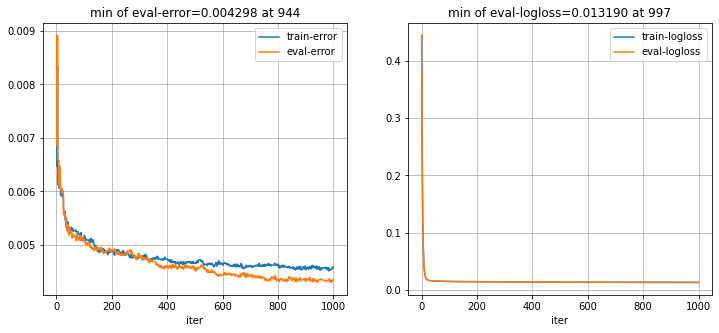

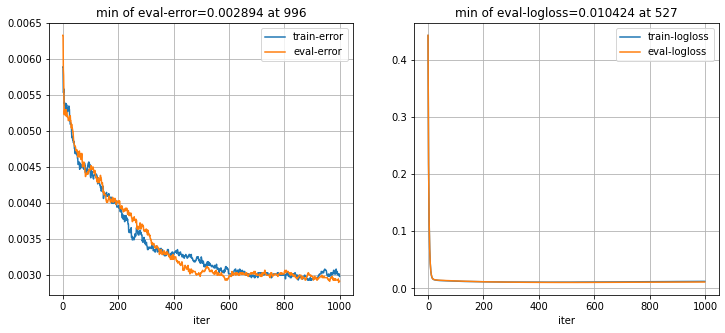

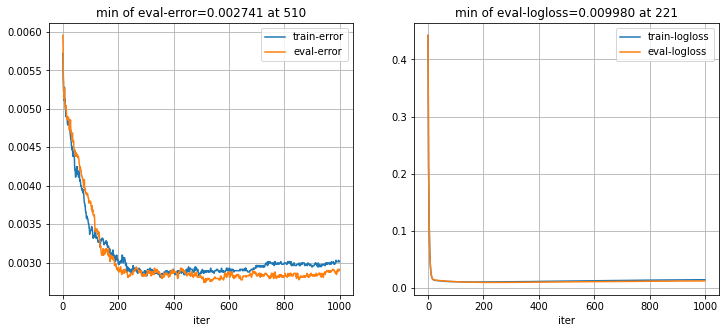

In [17]:
trainDM,testDM,allDM=split_data(original_feature_set)
evallist = [(trainDM, 'train'), (testDM, 'eval')]
trainDM,testDM,allDM=split_data(original_feature_set)
test_xgboost(depth=1,num_round=1000)
test_xgboost(depth=2,num_round=1000)
test_xgboost(depth=3,num_round=1000)

(59095, 41) (59095, 41) (59095,) (118190, 41)
test column= eval-error
test column= eval-logloss
test column= eval-error
test column= eval-logloss
test column= eval-error
test column= eval-logloss


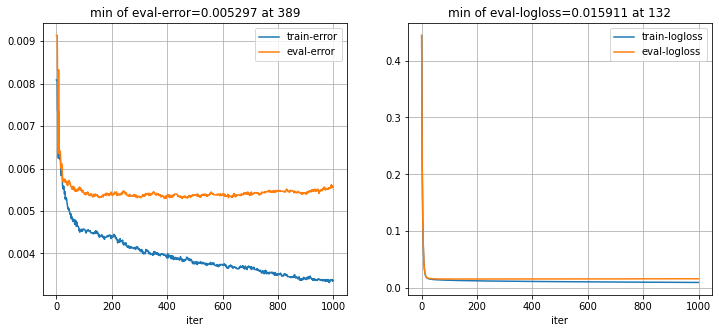

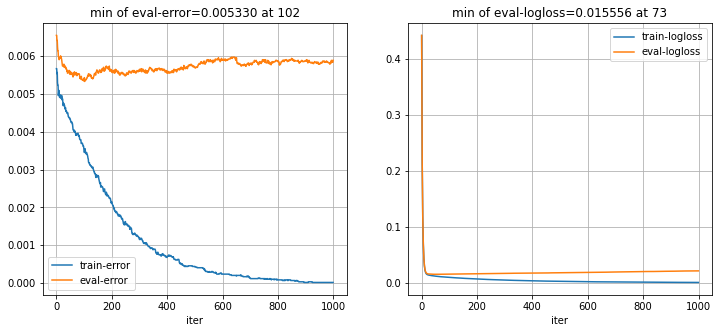

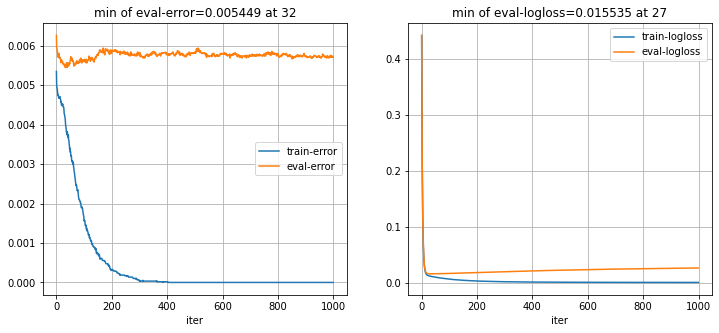

In [18]:
trainDM,testDM,allDM=split_data(original_feature_set)
evallist = [(trainDM, 'train'), (testDM, 'eval')]
test_xgboost(depth=1,num_round=1000)
test_xgboost(depth=2,num_round=1000)
test_xgboost(depth=3,num_round=1000)